In [1]:
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from data_loading import *
from hit import Hit
from track3D import Track3D
from track import Track
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import sys
from tqdm import tqdm
import scienceplots
plt.style.use(['science', 'grid', 'ieee'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    'text.latex.preamble': [r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})


In [2]:
# later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/geant4/data_decay6.root'

branch_list_detector = ['E', 'pdg', 'EcalEdep', 'layerID', 'barID', 'Nhits', 'Edep_e', 'Edep_mu']
branch_list_run = ['E', 'Edep', 'tx', 'ty', 'x0', 'y0', 'n_sec', 'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
branch_list_electrons = ['E', 'Vertex_E', 'muID']
with uproot.open(file_path) as tree:
        detector_dict = tree['detector'].arrays(branch_list_detector, library="np")
        run_dict = tree['run'].arrays(branch_list_run, library="np")
        electrons_dict = tree['electrons'].arrays(branch_list_electrons, library="np")

df_detector = pd.DataFrame.from_dict(detector_dict)
df_run = pd.DataFrame.from_dict(run_dict)
df_electrons = pd.DataFrame.from_dict(electrons_dict)
df = pd.concat([df_run, df_detector, df_electrons], axis=1)
# df = pd.merge(df, df_electrons)
og = len(df_detector)
df.query('ProcessID == 0', True)
print('kept {} events containing decays, {:.2f}% of all'.format(len(df), len(df)/og * 100))


kept 100000 events containing decays, 100.00% of all


In [3]:
from parameters import *

def get_hits(row):
    return [[row['barID'][i], row['layerID'][i], row['Edep_e'][i]] for i in range(len(row['barID']))
            if row['Edep_e'][i] > 0]
    # or row['ProcessID'] == 0

def DetectorCoord(pos):
    x = int(pos[0] / width)
    y = int(pos[1] / width)
    z = int(int(pos[2]) / (thickness + thickness_screen))
    if z % 2 == 0: # a layer measuring the x coordinate
        return True, x + 1, z/2 + 1
    else:
        return False, y + 1, (z-1)/2 + 1

def create_tracks(df, plot=False):
    tracks = []
    decay_pos = []
    decay_pos_det = []
    all_hits_x_x = []
    all_hits_x_z = []
    all_hits_y_y = []
    all_hits_y_z = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        hits = get_hits(row)
        # if len(hits) > 0:
        # only electron hits
        hitsX = [Hit([bar, (layer-1)/2 + 1], True, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 1]
        hitsY = [Hit([bar, layer/2 + 1], False, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 0]
        
        # get track parameters
        # if len(hitsX) > 0 and len(hitsY) > 0:
        track = Track3D()
        track.x = Track(hitsX)
        track.y = Track(hitsY)
        tracks.append(track)
        pos = np.array([row['x_decay'] + row['size_XY']/2, row['y_decay'] + row['size_XY']/2, row['z_decay'] + row['size_Z']/2])
        decay_pos.append(pos)
        decay_pos_det.append(DetectorCoord(pos))
        all_hits_x_x.extend([h.get_pos()[0] for h in track.x.hits])
        all_hits_x_z.extend([h.get_pos()[1] for h in track.x.hits])
        all_hits_y_y.extend([h.get_pos()[0] for h in track.y.hits])
        all_hits_y_z.extend([h.get_pos()[1] for h in track.y.hits])

    return tracks, decay_pos, decay_pos_det, all_hits_x_x, all_hits_x_z, all_hits_y_y, all_hits_y_z


In [4]:
tracks, decay_pos, decay_pos_det, all_hits_x_x, all_hits_x_z, all_hits_y_y, all_hits_y_z = create_tracks(df)


100%|██████████| 100000/100000 [13:41<00:00, 121.66it/s]


####### Track # 14809
decay position = 28.92, 17.88, 10.60
decay hit position = (29.60, 10.20)
decay hit position = (29.60, 0, 10.20)
max_dist = 10.968


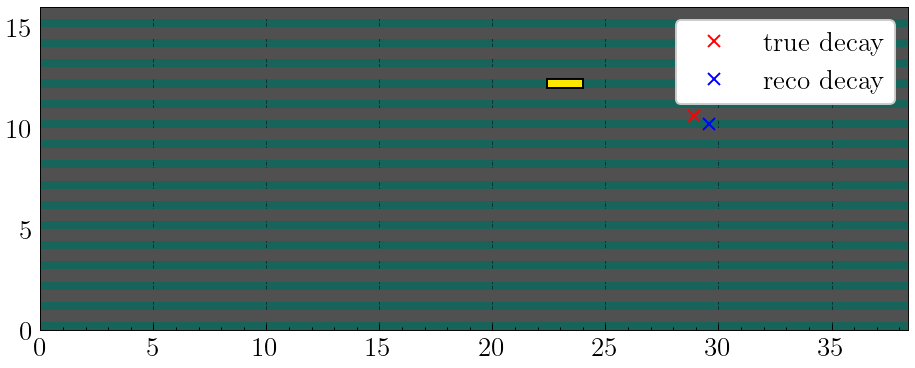

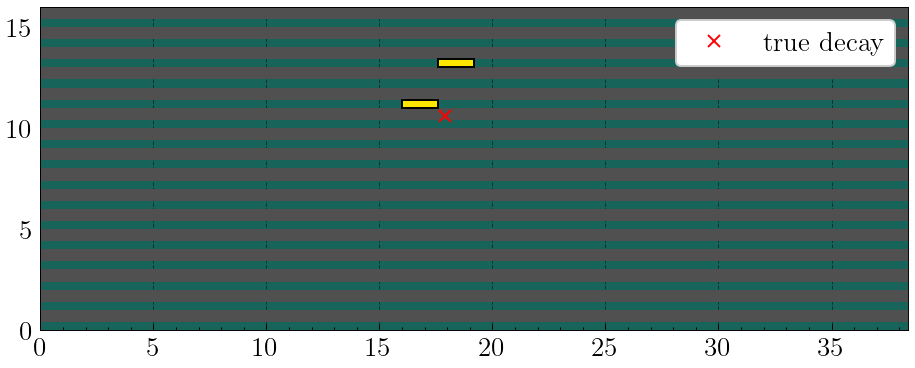

In [5]:
from track_reconstruction import plot_hits
gs = gridspec.GridSpec(2, 1)
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
all_hits = t.x.hits.copy()
all_hits.extend(t.y.hits)
decay_hit = Hit([decay_pos_det[i][1], decay_pos_det[i][2]], decay_pos_det[i][0], 0, 0, 1)
decay_hit_pos = decay_hit.get_pos()
fig1, axs1 = plot_hits(all_hits, True)
fig2, axs2 = plot_hits(all_hits, False)

print('decay position = {:.2f}, {:.2f}, {:.2f}'.format(decay_pos[i][0], decay_pos[i][1], decay_pos[i][2]))
print('decay hit position = ({:.2f}, {:.2f})'.format(decay_hit_pos[0], decay_hit_pos[1]))
axs1.plot([decay_pos[i][0]], [decay_pos[i][2]], 'rx', label='true decay')
axs2.plot([decay_pos[i][1]], [decay_pos[i][2]], 'rx', label = 'true decay')
if decay_pos_det[i][0]:
    axs1.plot([decay_hit_pos[0]], [decay_hit_pos[1]], 'bx', label='reco decay')
    print('decay hit position = ({:.2f}, 0, {:.2f})'.format(decay_hit_pos[0], decay_hit_pos[1]))
else:
    axs2.plot([decay_hit_pos[0]], [decay_hit_pos[1]], 'bx', label='reco decay')
    print('decay hit position = (0, {:.2f}, {:.2f})'.format(decay_hit_pos[0], decay_hit_pos[1]))
axs1.legend()
axs2.legend()
max_dist = 0
max_dist_hit = 0
for i in range(len(t.x.hits)):
    diff_z = t.x.hits[i].get_pos()[1] - decay_pos[i][2]
    diff_x = t.x.hits[i].get_pos()[0] - decay_pos[i][0]
    d = np.sqrt( diff_x**2 + diff_z**2 )
    if d > max_dist:
        max_dist = d
for i in range(len(t.y.hits)):
    diff_z = t.y.hits[i].get_pos()[1] - decay_pos[i][2]
    diff_y = t.y.hits[0].get_pos()[0] - decay_pos[i][1]
    d = np.sqrt( diff_y**2 + diff_z**2 )
    if d > max_dist:
        max_dist = d
        
print('max_dist = {:.3f}'.format(max_dist))
fig1.set_figheight(3)
fig1.set_figwidth(8)
fig2.set_figheight(3)
fig2.set_figwidth(8)


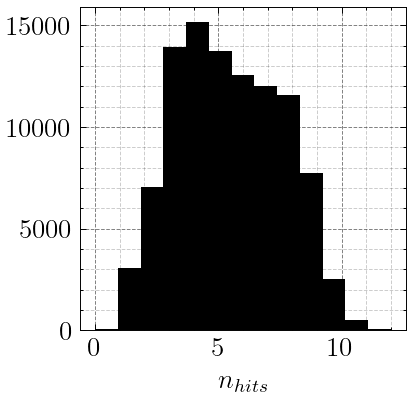

In [6]:
# hist of number of hits
n_hits = [len(t.x.hits) + len(t.y.hits) for t in tracks]
plt.figure(figsize=(3, 3))
plt.hist(n_hits, bins = 13, range = [0, 12])
plt.xlabel('$n_{hits}$')
plt.grid(which='major', alpha = 0.5)
plt.grid(which='minor', alpha=0.2)
plt.savefig('../../../figs/decay_n_hits.pdf')

In [7]:
# find max position
max_radius_cm = []
max_radius_cm_z = []
max_radius_cm_perp = []
max_radius_hit = []
max_radius_hit_z = []
max_radius_hit_perp = []
for t in tqdm(tracks, desc = 'tracks'):
    max_cm = 0
    max_cm_z = 0
    max_cm_perp = 0
    max_hit = 0
    max_hit_z = 0
    max_hit_perp = 0
    for i in range(len(t.x.hits)):
        diff_z = t.x.hits[i].get_pos()[1] - decay_pos[i][2]
        diff_x = t.x.hits[i].get_pos()[0] - decay_pos[i][0]
        diff_z_hit = t.x.hits[i].coord[1] - decay_pos_det[i][2]
        diff_x_hit = t.x.hits[i].coord[0] - decay_pos_det[i][0]
        d = np.sqrt( diff_x**2 + diff_z**2 )
        d_hit = np.sqrt(diff_z_hit**2 + diff_x_hit**2)  # diff_z_hit #
        if d > max_cm: # max radius
            max_cm = d
        if np.abs(diff_z) > max_cm_z: # max distance along z
            max_cm_z = np.abs(diff_z)
        if np.abs(diff_x) > max_cm_perp:  # max distance perp to z
            max_cm_perp = np.abs(diff_x)
        if d_hit > max_hit: # max radius in cells
            max_hit = d_hit
        if diff_z_hit > max_hit_z: # max radius in cells along z
            max_hit_z = diff_z_hit
        if diff_x_hit > max_hit_perp:  # max radius in cells perp to z
            max_hit_perp = diff_x_hit
    for i in range(len(t.y.hits)):
        diff_z = t.y.hits[i].get_pos()[1] - decay_pos[i][2]
        diff_y = t.y.hits[0].get_pos()[0] - decay_pos[i][1]
        diff_z_hit = t.y.hits[i].coord[1] - decay_pos_det[i][2]
        diff_y_hit = t.y.hits[i].coord[0] - decay_pos_det[i][1]
        d = np.sqrt( diff_y**2 + diff_z**2 )
        d_hit = np.sqrt(diff_z_hit**2 + diff_y_hit**2)  # diff_z_hit  #
        if d > max_cm: # max radius
            max_cm = d
        if np.abs(diff_z) > max_cm_z: # max distance along z
            max_cm_z = np.abs(diff_z)
        if np.abs(diff_y) > max_cm_perp:  # max distance perp to z
            max_cm_perp = np.abs(diff_y)
        if d_hit > max_hit: # max radius in cells
            max_hit = d_hit
        if diff_z_hit > max_hit_z: # max radius in cells along z
            max_hit_z = diff_z_hit
        if diff_y_hit > max_hit_perp:  # max radius in cells perp to z
            max_hit_perp = diff_y_hit
    max_radius_cm.append(max_cm)
    max_radius_cm_z.append(max_cm_z)
    max_radius_cm_perp.append(max_cm_perp)
    max_radius_hit.append(max_hit)
    max_radius_hit_z.append(max_hit_z)
    max_radius_hit_perp.append(max_hit_perp)
   

tracks: 100%|██████████| 100000/100000 [00:07<00:00, 13315.63it/s]


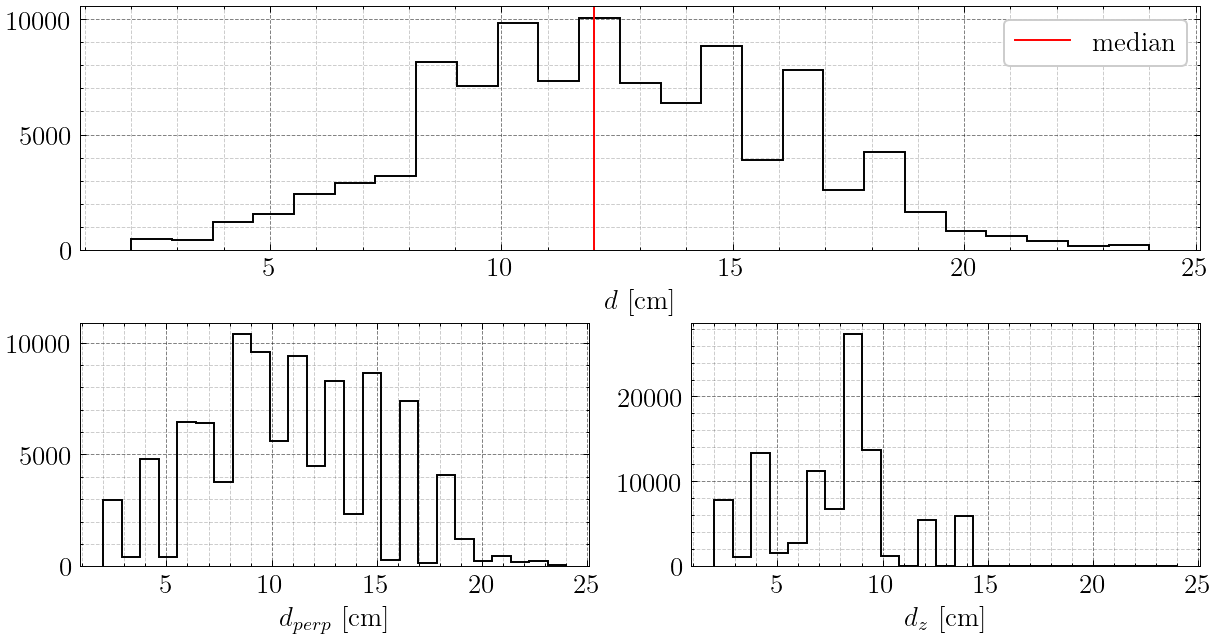

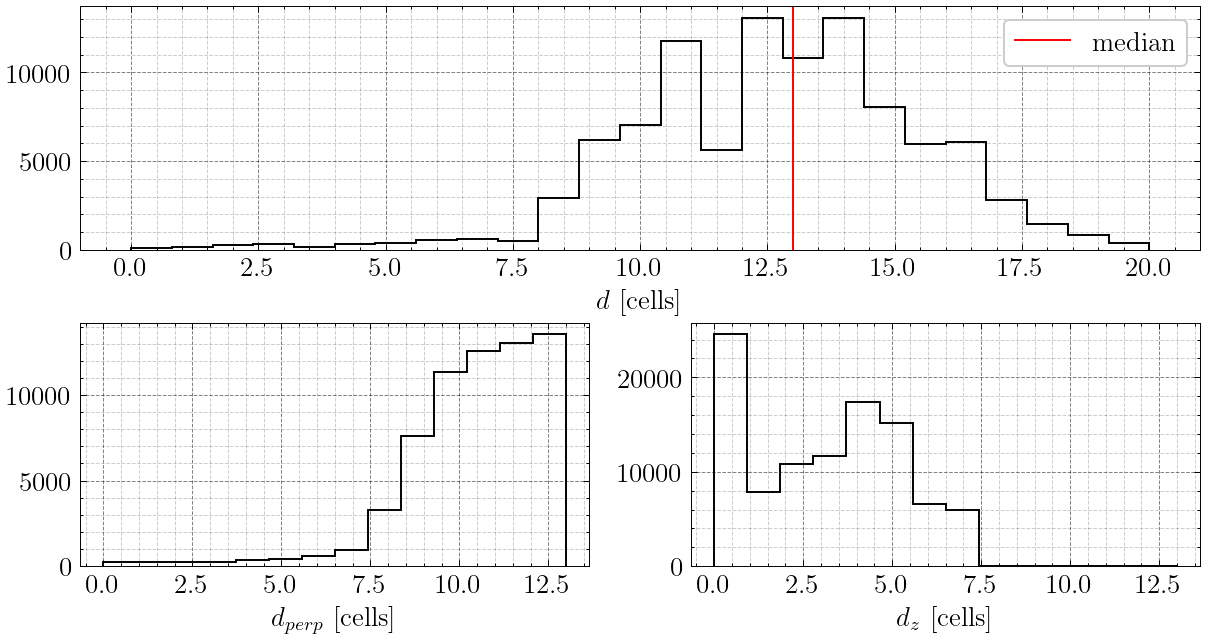

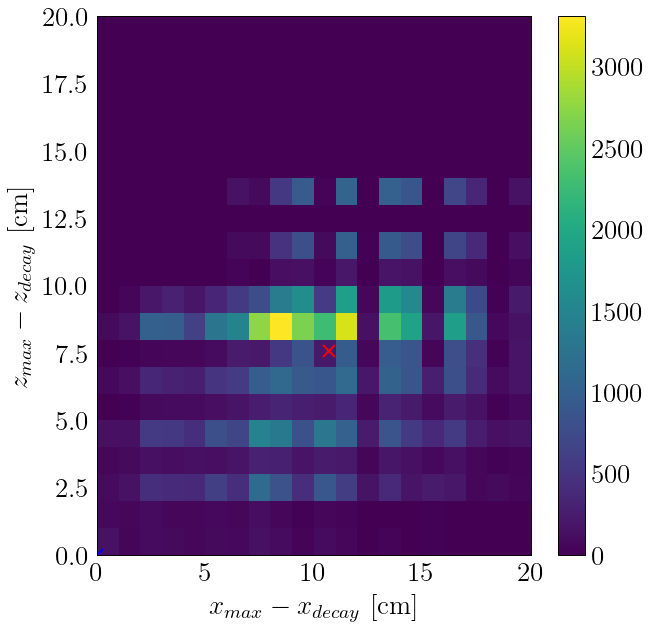

In [15]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
bins = 25

fig = plt.figure(figsize = (10, 5))
ax0 = fig.add_subplot(gs[0, :])  # row 1, span all columns
ax0.hist(max_radius_cm, bins=bins, range=[2, 24], histtype='step')
ax0.axvline(np.median(max_radius_cm), 0, 1, c='r', label='median')
ax0.set(xlabel='$d$ [cm]')
ax0.legend()
ax0.grid(which = 'major', alpha = 0.5)
ax0.grid(which = 'minor', alpha = 0.2)
ax1 = fig.add_subplot(gs[1, 1]) # row 0, col 0
ax1.hist(max_radius_cm_z, bins = bins, range = [2, 24], histtype = 'step')
ax1.set(xlabel = '$d_z$ [cm]')
ax1.grid(which='major', alpha=0.5)
ax1.grid(which='minor', alpha=0.2)
ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
ax2.hist(max_radius_cm_perp, bins = bins, range = [2, 24], histtype = 'step')
ax2.set(xlabel = '$d_{perp}$ [cm]')
ax2.grid(which='major', alpha=0.5)
ax2.grid(which='minor', alpha=0.2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()
fig.savefig('../../../figs/electron_distance.pdf')

bins = 25
fig = plt.figure(figsize = (10, 5))
ax0 = fig.add_subplot(gs[0, :])  # row 1, span all columns
ax0.hist(max_radius_hit, bins=bins, range=[0, 20], histtype='step')
ax0.axvline(np.median(max_radius_hit), 0, 1, c='r', label='median')
ax0.legend()
ax0.set(xlabel='$d$ [cells]')
ax0.grid(which = 'major', alpha = 0.5)
ax0.grid(which = 'minor', alpha = 0.2)
ax1 = fig.add_subplot(gs[1, 1]) # row 0, col 0
ax1.hist(max_radius_hit_z, bins=14, range=[0, 13], histtype = 'step')
ax1.set(xlabel = '$d_z$ [cells]')
ax1.grid(which='major', alpha=0.5)
ax1.grid(which='minor', alpha=0.2)
ax2 = fig.add_subplot(gs[1, 0]) # row 0, col 1
ax2.hist(max_radius_hit_perp, bins = 14, range = [0, 13], histtype = 'step')
ax2.set(xlabel = '$d_{perp}$ [cells]')
ax2.grid(which='major', alpha=0.5)
ax2.grid(which='minor', alpha=0.2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()
fig.savefig('../../../figs/electron_distance_cells.pdf')

fig, axs = plt.subplots(1, 1, figsize = [5, 5])
h = axs.hist2d(max_radius_cm_perp, max_radius_cm_z, bins = [20, 20], range = [[0, 20], [0, 20]])
axs.plot([np.mean(max_radius_cm_perp)], [np.mean(max_radius_cm_z)], 'rx', label = 'mean')
axs.plot([0], [0], 'bx', label = 'decay')
axs.set(xlabel = '$x_{max} - x_{decay}$ [cm]', ylabel = '$z_{max} - z_{decay}$ [cm]')
fig.colorbar(h[3], ax = axs)


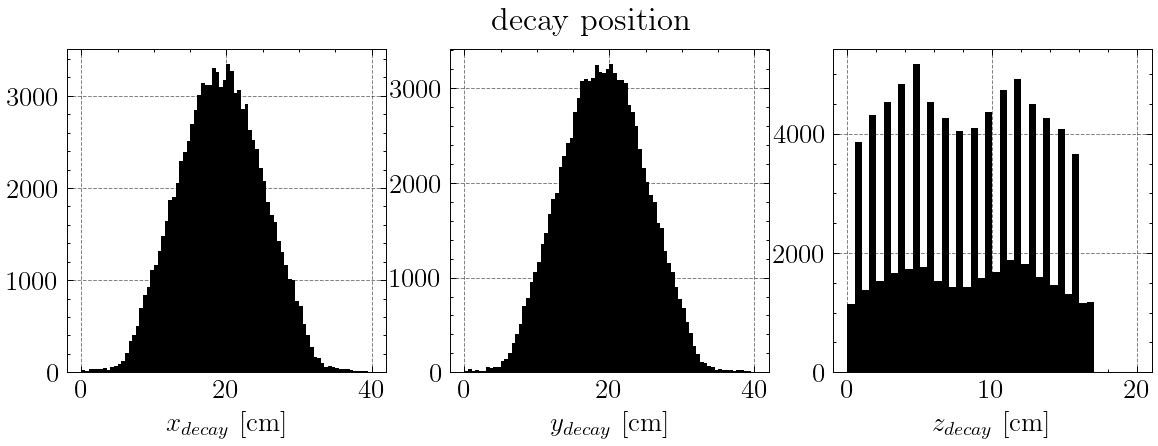

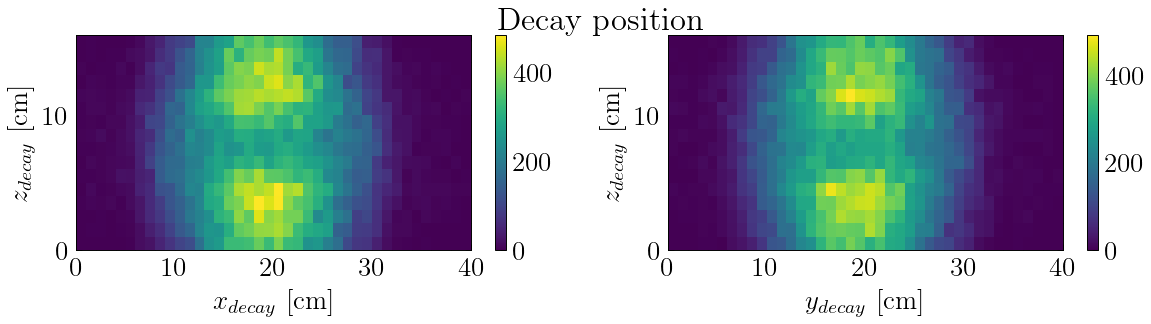

In [9]:
fig, axs = plt.subplots(1, 3, figsize = (10, 3))
fig.suptitle('decay position')
axs[0].hist([pos[0] for pos in decay_pos], bins = 80, range = [0, 40])
axs[0].set(xlabel = '$x_{decay}$ [cm]')
axs[1].hist([pos[1] for pos in decay_pos], bins=80, range = [0, 40])
axs[1].set(xlabel = '$y_{decay}$ [cm]')
axs[2].hist([pos[2] for pos in decay_pos], bins=40, range = [0, 20])
axs[2].set(xlabel = '$z_{decay}$ [cm]')

fig, axs = plt.subplots(1, 2, figsize = [10, 2])
fig.suptitle('Decay position')
h = axs[0].hist2d([pos[0] for pos in decay_pos], [pos[2] for pos in decay_pos], bins = [40, 16], range = [[0, 40], [0, 16]])
axs[0].set(xlabel = '$x_{decay}$ [cm]', ylabel = '$z_{decay}$ [cm]')
fig.colorbar(h[3], ax = axs[0])
h = axs[1].hist2d([pos[1] for pos in decay_pos], [pos[2] for pos in decay_pos], bins = [40, 16], range = [[0, 40], [0, 16]])
axs[1].set(xlabel = '$y_{decay}$ [cm]', ylabel = '$z_{decay}$ [cm]')
fig.colorbar(h[3], ax=axs[1])


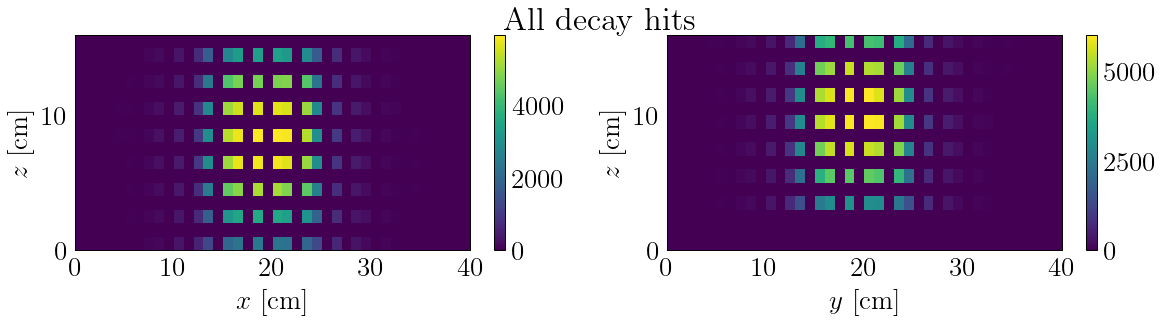

In [10]:
fig, axs = plt.subplots(1, 2, figsize = [10, 2])
fig.suptitle('All decay hits')
h = axs[0].hist2d(all_hits_x_x, all_hits_x_z, bins = [40, 16], range = [[0, 40], [0, 16]])
axs[0].set(xlabel = '$x$ [cm]', ylabel = '$z$ [cm]')
fig.colorbar(h[3], ax = axs[0])
h = axs[1].hist2d(all_hits_y_y, all_hits_y_z, bins = [40, 16], range = [[0, 40], [0, 16]])
axs[1].set(xlabel = '$y$ [cm]', ylabel = '$z$ [cm]')
fig.colorbar(h[3], ax = axs[1])

tracks: 100%|██████████| 100000/100000 [00:00<00:00, 780883.34it/s]


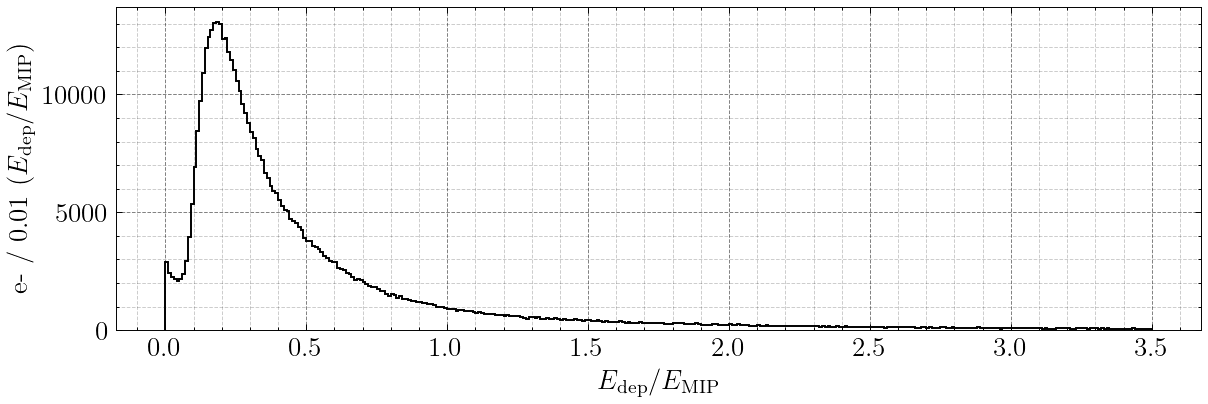

In [17]:
# energy distribution in units of MIPs
edeps = []
for t in tqdm(tracks, desc = 'tracks'):
    edeps.extend([h.value for h in t.x.hits])
    edeps.extend([h.value for h in t.y.hits])
    
edeps = np.array(edeps)

plt.figure(figsize = (10, 3))
# plt.title('{} events'.format(len(edeps)))
h, e, _ = plt.hist(edeps / 1.47918, bins=350, range=[0, 3.5], label='data', histtype='step')
m = np.mean(edeps)
e = np.array(e) + (e[1] - e[0])/2
maxi = e[np.argmax(h)]
# plt.axvline(m, 0, 1, c = 'k', label = 'mean {:.3f}'.format(m))
# plt.axvline(maxi, 0, 1, c='r', label='max {:.3f}'.format(maxi))
# plt.legend()
plt.xlabel(r'$E_\mathrm{dep} / E_\mathrm{MIP}$')
plt.ylabel(r'e- / 0.01 ($E_\mathrm{dep}/E_\mathrm{MIP}$)')
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.2)
plt.savefig('../../../figs/decay_electrons_edep.pdf')
